In [ ]:
!pip install gpytorch &> /dev/null
!pip install botorch &> /dev/null

In [ ]:
# importing essential packages
from botorch import fit_gpytorch_mll
import gpytorch
from gpytorch.constraints import Positive
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy.stats as stats
from sklearn.datasets import fetch_openml
import torch

# PYTORCH FUNDAMENTALS




In [ ]:
# Tensor Manipulation
torch.manual_seed(42)

a = torch.rand((3,3))
b = a+1

c = a @ a.T

# print the results
print("a is")
print(a)
print("b is")
print(b)
print("c is")
print(c)

a is
tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408]])
b is
tensor([[1.8823, 1.9150, 1.3829],
        [1.9593, 1.3904, 1.6009],
        [1.2566, 1.7936, 1.9408]])
c is
tensor([[1.7622, 1.4337, 1.3127],
        [1.4337, 1.4338, 1.1213],
        [1.3127, 1.1213, 1.5807]])


In [ ]:
# Automatic Differentiation
x = torch.tensor(2.0, requires_grad = True)
y = torch.tensor(3.0, requires_grad = True)

z = x*y + y**2

z.backward()

print(x.item(),y.item())
print(z.item())

# print results
print(f"dz/dx at x={x.item()} and y={y.item()}:  {x.grad.item()}")  # Should be y (3.0)
print(f"dz/dy at x={x.item()} and y={y.item()}:  {y.grad.item()}")  # Should be x + 2*y (2.0 + 6.0 = 8.0)


2.0 3.0
15.0
dz/dx at x=2.0 and y=3.0:  3.0
dz/dy at x=2.0 and y=3.0:  8.0


In [ ]:
# Automatic Differentiation: Batching
x = torch.tensor([2.0,4.0,6.0], requires_grad = True)
y = torch.tensor([3.0,5.0,7.0], requires_grad = True)

z = x*y + y**2
# .backward() works only on scalars, so we need to define
# another tensor element to define how we treat the elements
# into a single scalar value to compute gradients
z.backward(torch.ones_like(z))

# print results
print(x)
print(y)
print(z)
print(x.grad.detach().numpy())
print(y.grad.detach().numpy())

tensor([2., 4., 6.], requires_grad=True)
tensor([3., 5., 7.], requires_grad=True)
tensor([15., 45., 91.], grad_fn=<AddBackward0>)
[3. 5. 7.]
[ 8. 14. 20.]


# GAUSSIAN PROCESSES - SCRATCH

In [ ]:
# RBF KERNEL
# Your goal is to implement a Python function that evaluates the
# RBF kernel between two sets of points. The structure of the
# function (with all inputs and outputs) is provided in the code
# block below -- your goal is to complete the function.
# Note that your function needs to support batching, so I
# recommend that you use the torch.cdist function to compute
# for a batch of inputs.

def rbf_kernel(x1, x2, l = 1.0, a = 1.0):
    if len(x1.shape)==1:
        x1 = x1.unsqueeze(-1)
    if len(x2.shape)==1:
        x2 = x2.unsqueeze(-1)
    sqdist = torch.cdist(x1,x2)**2
    rbf = a**2 * torch.exp(-sqdist/(2*(l**2)))
    return rbf

In [ ]:
l = 1.0
a = 1.0

x = torch.linspace(-2,2,101)
y = torch.linspace(-3,1,101)
X, Y = torch.meshgrid(x,y)

with torch.no_grad():
  K = rbf_kernel(x,x,l,a)
K = K.detach().numpy()

print(x,"\t",x.shape,"\n")
print(y,"\t",y.shape,"\n")
print(X,"\t",X.shape,"\n")
print(Y,"\t",Y.shape,"\n")
print(K,"\t",K.shape,"\n")


tensor([-2.0000e+00, -1.9600e+00, -1.9200e+00, -1.8800e+00, -1.8400e+00,
        -1.8000e+00, -1.7600e+00, -1.7200e+00, -1.6800e+00, -1.6400e+00,
        -1.6000e+00, -1.5600e+00, -1.5200e+00, -1.4800e+00, -1.4400e+00,
        -1.4000e+00, -1.3600e+00, -1.3200e+00, -1.2800e+00, -1.2400e+00,
        -1.2000e+00, -1.1600e+00, -1.1200e+00, -1.0800e+00, -1.0400e+00,
        -1.0000e+00, -9.6000e-01, -9.2000e-01, -8.8000e-01, -8.4000e-01,
        -8.0000e-01, -7.6000e-01, -7.2000e-01, -6.8000e-01, -6.4000e-01,
        -6.0000e-01, -5.6000e-01, -5.2000e-01, -4.8000e-01, -4.4000e-01,
        -4.0000e-01, -3.6000e-01, -3.2000e-01, -2.8000e-01, -2.4000e-01,
        -2.0000e-01, -1.6000e-01, -1.2000e-01, -8.0000e-02, -4.0000e-02,
         4.4703e-08,  4.0000e-02,  8.0000e-02,  1.2000e-01,  1.6000e-01,
         2.0000e-01,  2.4000e-01,  2.8000e-01,  3.2000e-01,  3.6000e-01,
         4.0000e-01,  4.4000e-01,  4.8000e-01,  5.2000e-01,  5.6000e-01,
         6.0000e-01,  6.4000e-01,  6.8000e-01,  7.2

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


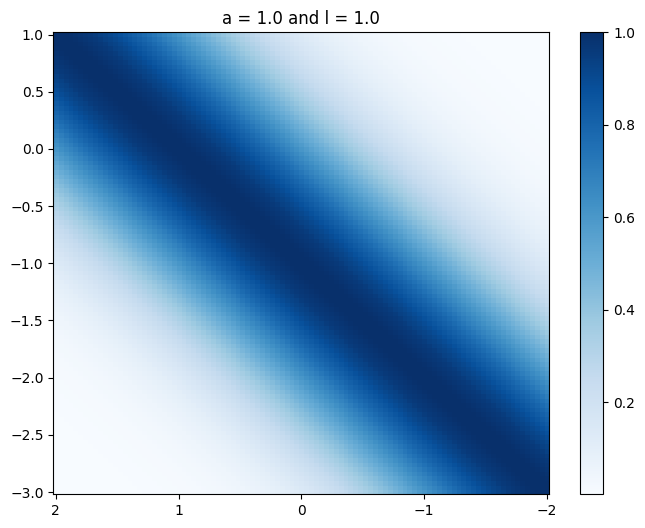

In [ ]:
fig,ax = plt.subplots(1,1, figsize = (8,6))
c = ax.pcolor(X,Y,K, cmap = cm.Blues)
ax.invert_xaxis()
ax.set_title(f'a = {a} and l = {l}')
fig.colorbar(c, ax=ax)
plt.rcParams.update({'font.size':14});

# GP PRIOR - sampling
1. We have thusfar generated the RBF Kernel which is a vector explaining datapoint dependencies
2. Now we generate random data samples
3. Perform choesky decompositon of kernel to generate prior function on the random vector

#### *NEED TO DO THIS:*
to see the functions and smoothness the model is able to generate without being conditioned

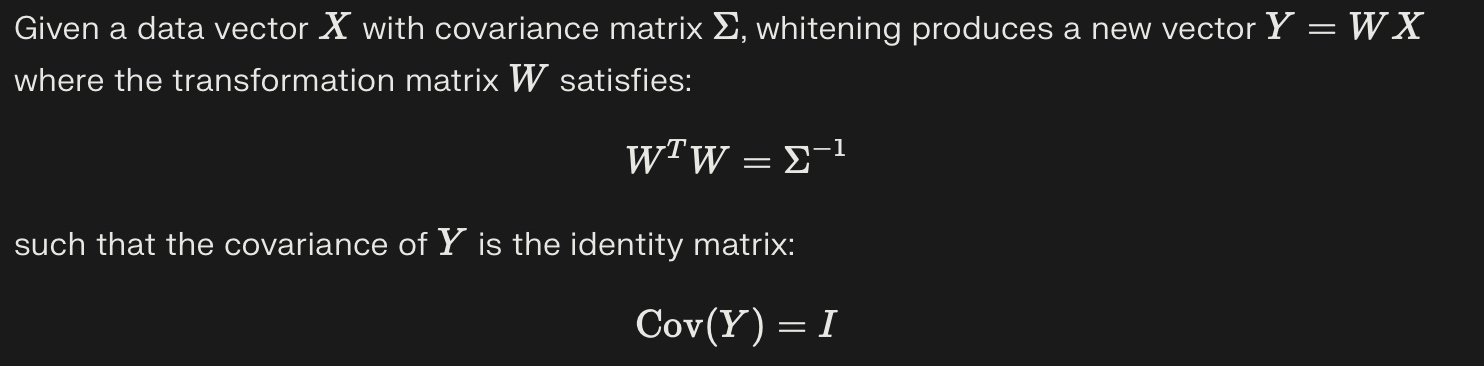

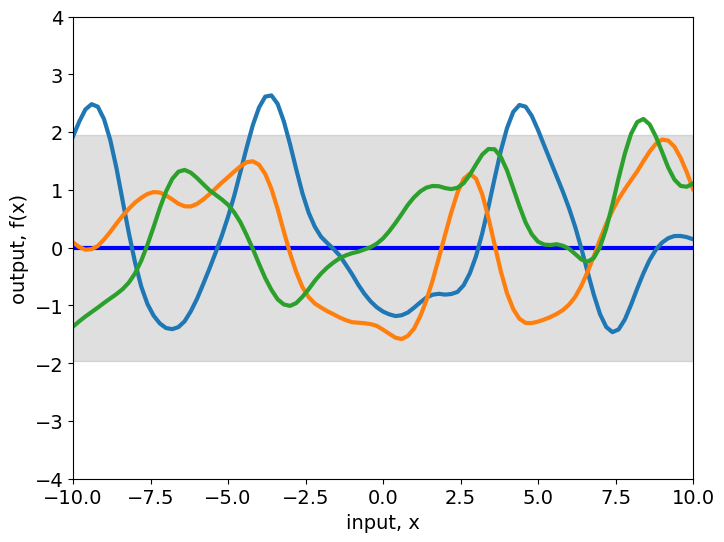

In [ ]:
torch.manual_seed(42)

x = torch.linspace(-10,10,101)

with torch.no_grad():
  K = rbf_kernel(x,x,l,a)

# cholosky is sometimes problematic if its not a positive definite
# matrix. so we add a noise value to counter that
L = torch.linalg.cholesky(K + 1e-5*torch.eye(len(x)))

# create a plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# add the 95% confidence region to plot
sigma = K.diag().sqrt()
lq = sigma*stats.norm.ppf(0.025)
uq = sigma*stats.norm.ppf(0.975)
plt.plot(x, torch.zeros(len(x)), '-b', linewidth=3)
plt.fill_between(x, lq, uq, color='gray', alpha=0.25)

# add three sample realizations to plot
for i in range(3):
  f = torch.matmul(L, torch.randn((len(x),1)))
  plt.plot(x.detach().numpy(), f.detach().numpy(), "-", linewidth=3)


# set limits, labels, and font size
plt.xlim([-10,10])
plt.ylim([-4,4])
plt.xlabel('input, x')
plt.ylabel('output, f(x)')
plt.rcParams.update({'font.size':14});

# GP POSTERIOR - sampling
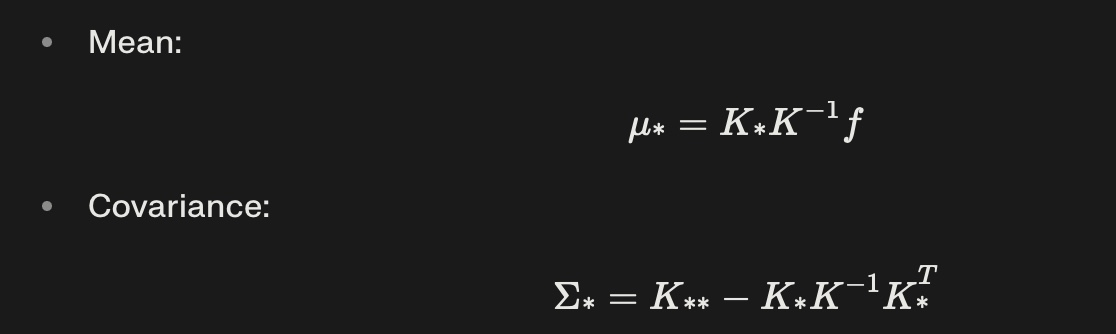

* K** - covariance matrix(test points)
* K* - covariance matrix (test and train)
* K - convariance matrix (train points)

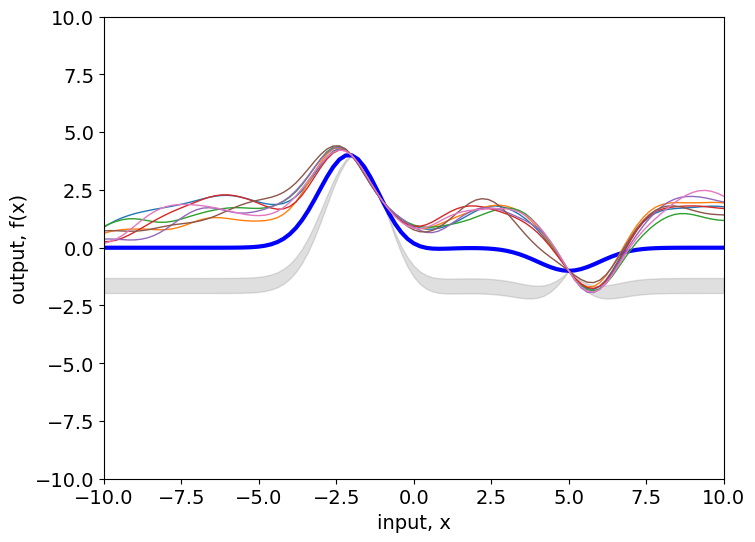

In [ ]:
torch.manual_seed(42)

x_test = torch.linspace(-10,10,101)

# create training data given in problem statement
x_train = torch.tensor([-1.0,-2.0,5.0])
y_train = torch.tensor([2.0,4.0,-1.0])

# need to evaluate the rbf kernel between different train, test combinations
a,l = 1.0, 1.0
K_train_train = rbf_kernel(x_train, x_train, l, a)
K_test_test = rbf_kernel(x_test, x_test, l, a)
K_train_test = rbf_kernel(x_test, x_train, l, a)

# now we can compute the posterior
# now we can run the conditional calculation since means are 0
# by assumption
k_inv_train_train = torch.inverse(K_train_train)
gp_mean = K_train_test @ k_inv_train_train @ y_train.unsqueeze(-1)
gp_cov = K_test_test - (K_train_test @ k_inv_train_train) @ K_train_test.T

# we can then generate samples using the same whitening transformation idea as before
# but now we also need to track the mean function
L = torch.linalg.cholesky(gp_cov + 1e-5*torch.eye(len(x_test)))

# create a plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# add the 95% confidence region, where we now need to account for the mean
std = gp_cov.diag().sqrt()
lower_q = gp_mean.squeeze() + std*stats.norm.ppf(0.025)
upper_q = gp_mean.squeeze() + std*stats.norm.ppf(0.095)
plt.plot(x_test, gp_mean.squeeze(), '-b', linewidth=3)
plt.fill_between(x_test, lower_q, upper_q, color='gray', alpha=0.25)

# add three sample realizations
for i in range(7):
  f = torch.matmul(L,torch.rand((len(x_test),1))) + gp_mean.reshape(-1,1)
  plt.plot(x_test.detach().numpy(), f.detach().numpy(), "-",linewidth = 1)

# set limits, labels, and font size
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('input, x')
plt.ylabel('output, f(x)')
plt.rcParams.update({'font.size':14});

#### INTERPRETATION:
* blue line -  true interpretation of test data after observing training data
* gray region - region of uncertainity
* Three colored lines - the fit of random values given the already learnt mean



# FIND THE HYPERPARAMETERS
Marginal Log Likelihood:
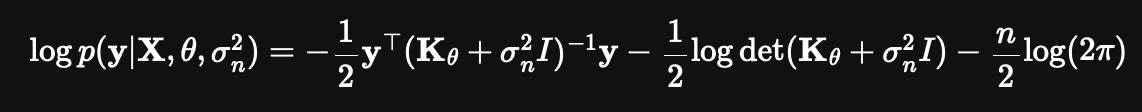

MLL estimates how good a set of hyperparamters are (in the sense, how close it is to representing the original mean)
* **HIGH MLL** - good fit, less complex
* **LOW MLL** - bad fit

*MLL explain both how good the fit is and the smoothness of the function*


In [ ]:
def gp_prior(x, l=0.1,a=0.1,n_samples=3,plot_on=True):
  with torch.no_grad():
    K = rbf_kernel(x,x,l,a)

  mu = torch.zeros((len(x),1)) #mean is considered 0 for prior evaluation
  L = torch.cholesky(K + (1e-5)*torch.eye(len(x)))

  gp_prior = torch.zeros((len(x),n_samples))
  for i in range(n_samples):
    gp_prior[:,i] = torch.matmul(L,torch.randn((len(x),1))).squeeze()

  if plot_on:
    fig,ax = plt.subplots(1,1,figsize=(10,8))

    sigma = K.diag().sqrt()
    lq = sigma*stats.norm.ppf(0.025)
    uq = sigma*stats.norm.ppf(0.975) # Corrected percentile for 95% confidence
    plt.plot(x,torch.zeros(len(x)),"-b",linewidth =3) #mean line
    plt.fill_between(x,lq,uq,color="gray",alpha=0.25) #variance

    for i in range(n_samples):
      plt.plot(x.detach().numpy(),gp_prior[:,i].detach().numpy(),"-",linewidth=1)

    plt.xlim([-10,10])
    plt.ylim([-4,4]) # Adjusted y-limit for better visualization
    plt.xlabel("input x")
    plt.ylabel("output f(x)")
    plt.show() # Moved plt.show() inside the if block

  return mu, K, gp_prior

In [ ]:
def gp_posterior(x_test,x_train,y_train,l=0.1,a=0.1,n_samples=3,plot_on=True):
  with torch.no_grad():
    K_test_test = rbf_kernel(x_test,x_test,l,a)
    K_train_train = rbf_kernel(x_train,x_train,l,a)
    K_train_test = rbf_kernel(x_train,x_test,l,a)

  L_train = torch.linalg.cholesky(K_train_train + (1e-5)*torch.eye(len(x_train)))
  # we previously used torch.inverse since it was a small vector but for bigger
  # vectors we use torch.cholesky_solve
  alpha = torch.cholesky_solve(y_train.unsqueeze(-1), L_train)
  post_mu = K_train_test.T @ alpha
  v = torch.cholesky_solve(K_train_test, L_train)
  post_cv = K_test_test - (K_train_test.T @ v)

  L_post = torch.linalg.cholesky(post_cv + (1e-5)*torch.eye(len(x_test)))
  post_mu = post_mu.squeeze()
  gp_posterior = torch.zeros((len(x_test),n_samples))
  for i in range(n_samples):
    gp_posterior[:,i] = torch.matmul(L_post,torch.randn((len(x_test),1))).squeeze() + post_mu.unsqueeze(-1).squeeze()


  if plot_on:
    fig, ax = plt.subplots(1,1,figsize=(10,8))
    sigma = post_cv.diag().sqrt()
    lq = sigma**stats.norm.ppf(0.025) + post_mu
    uq = sigma**stats.norm.ppf(0.075) + post_mu
    plt.plot(x_test,post_mu,"-b",linewidth=3)
    plt.fill_between(x_test.detach().numpy(),lq.detach().numpy(),uq.detach().numpy(),color="gray",alpha=0.25)

    for i in range(n_samples):
      plt.plot(x_test.detach().numpy(),gp_posterior[:,i].detach().numpy(),"-",linewidth=1)

    plt.scatter(x_train,y_train,color="red",marker="x")
    plt.xlim([-10,10])
    plt.ylim([-10,50])
    plt.xlabel("input x")
    plt.ylabel("output f(x)")
    plt.rcParams.update({'font.size': 20})
    plt.show()

  return post_mu, post_cv, gp_posterior

/tmp/ipython-input-926147086.py:6: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1765.)
  L = torch.cholesky(K + (1e-5)*torch.eye(len(x)))


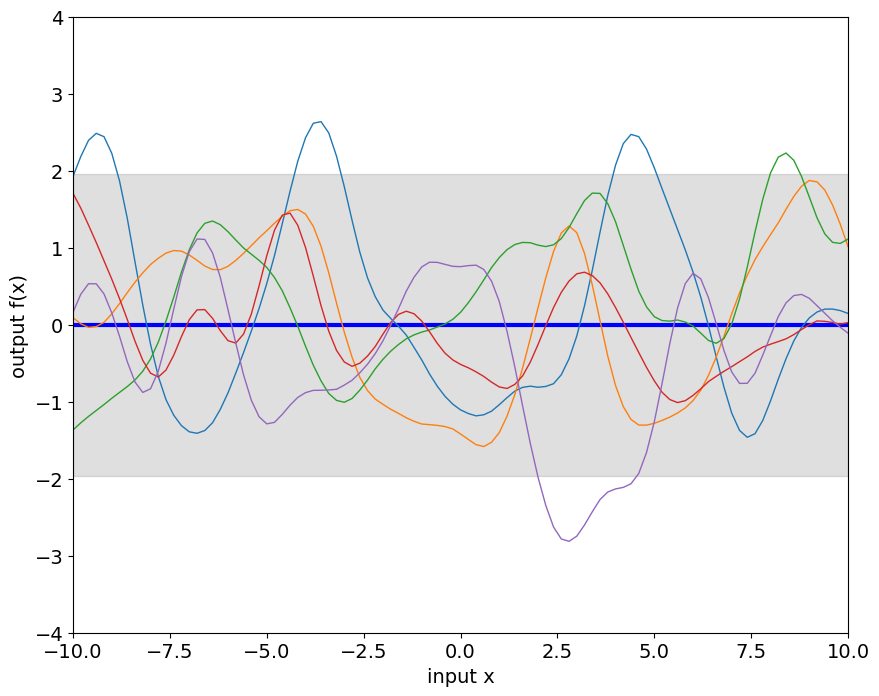

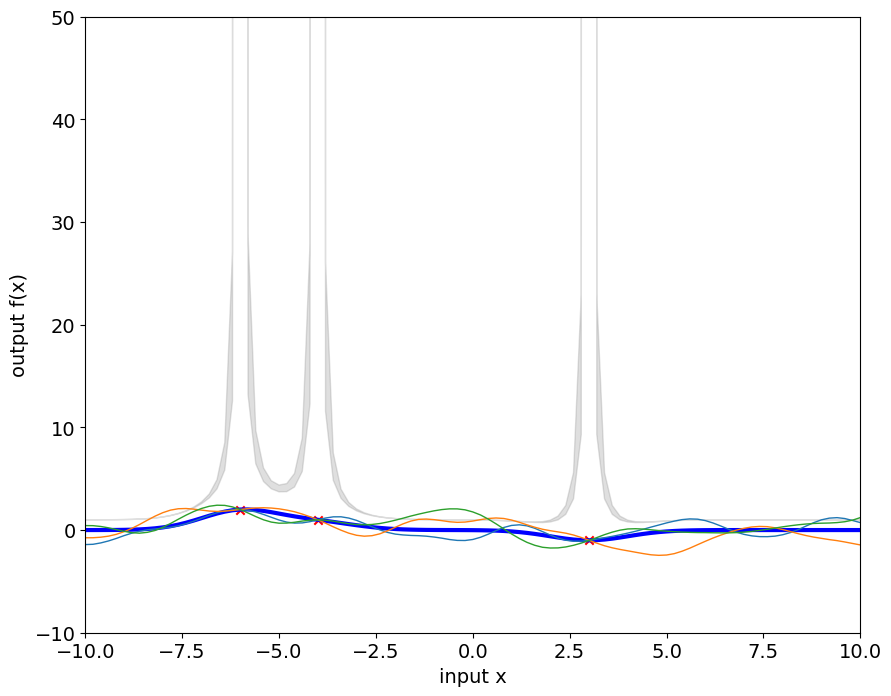

In [ ]:
x_test = torch.linspace(-10,10,101)
x_train = torch.tensor([-6.0,-4.0,3.0])
y_train = torch.tensor([2.0,1.0,-1.0])

torch.manual_seed(42)
prior_mean, prior_cov, prior_sample_paths = gp_prior(x_test, l=1, a=1, n_samples=5, plot_on=True);

# torch.manual_seed(42)
post_mean, post_cov, post_sample_paths = gp_posterior(x_test, x_train, y_train, l=1, a=1, n_samples=3, plot_on=True)

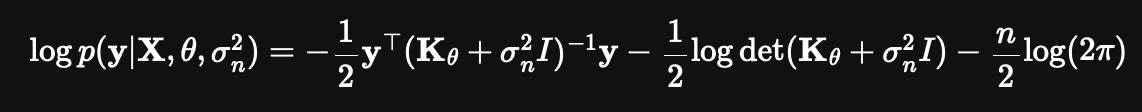

tensor([-11.8682, -11.8682, -11.8682, -11.8682, -11.8682, -11.8682, -11.8678,
        -11.8667, -11.8638, -11.8580, -11.8481, -11.8329, -11.8119, -11.7847,
        -11.7515, -11.7125, -11.6684, -11.6196, -11.5667, -11.5103, -11.4509,
        -11.3889, -11.3246, -11.2583, -11.1903, -11.1207, -11.0496, -10.9770,
        -10.9031, -10.8278, -10.7512, -10.6734, -10.5943, -10.5140, -10.4325,
        -10.3499, -10.2664, -10.1818, -10.0965, -10.0105,  -9.9240,  -9.8372,
         -9.7502,  -9.6634,  -9.5769,  -9.4911,  -9.4064,  -9.3231,  -9.2416,
         -9.1625,  -9.0863,  -9.0138,  -8.9456,  -8.8826,  -8.8259,  -8.7766,
         -8.7360,  -8.7059,  -8.6879,  -8.6842,  -8.6975,  -8.7304,  -8.7864,
         -8.8692,  -8.9830,  -9.1325,  -9.3229,  -9.5593,  -9.8474, -10.1927,
        -10.6001, -11.0744, -11.6181, -12.2341, -12.9217, -13.6797, -14.5035,
        -15.3954, -16.3372, -17.3339, -18.3714, -19.4465, -20.5513, -21.6865,
        -22.8496, -24.0272, -25.2181, -26.4433, -27.6764, -28.94

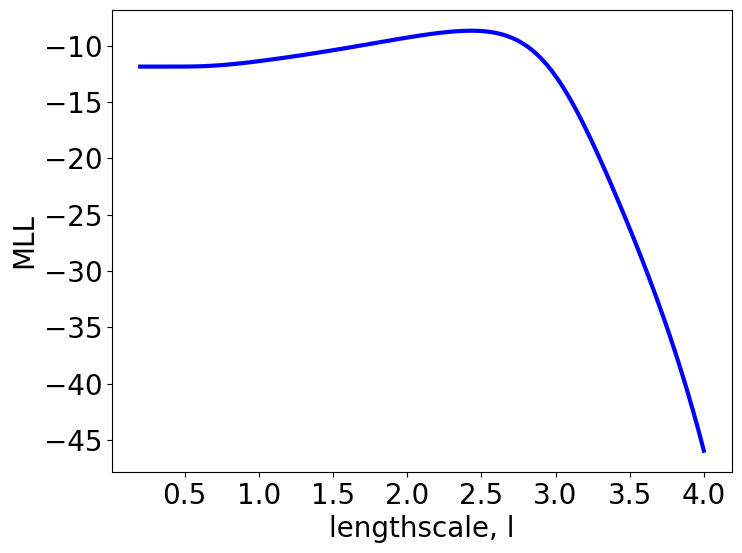

In [ ]:
# observed data
x_train = torch.Tensor([-8.0000, -6.2222, -4.4444, -2.6667, -0.8889,  0.8889,  2.6667,  4.4444,   6.2222,  8.0000])
y_train = torch.Tensor([-1.1544, -0.9582,  0.3840,  1.0536,  0.2901, -0.6560, -0.9193, -0.2800,   0.3737,  0.5213])

# create a function that evaluates the MLL given y and K
def max_LL(y,K,sigma2_noise):
  n = y.shape[0]
  y = y.reshape(-1,1)
  Ky = K + sigma2_noise*torch.eye(n)
  L = torch.linalg.cholesky(Ky)
  alpha = torch.cholesky_solve(y,L)
  mll = -0.5*y.T @ alpha - 0.5*torch.sum(torch.log(torch.diag(L))) - 0.5 * n* np.log(2*np.pi)
  return mll.item()


# create test points at which to evaluate the
x_test = torch.linspace(-10, 10, 101)

# create a list of possible lengthscale values
l_list = torch.linspace(0.2, 4, 101)

# evaluate the mll for all values in this list
a_true = 1
sigma2_noise = 1e-4
mll_list = torch.zeros(len(l_list))
for i in range(len(l_list)):
    ### FILL IN
    ### Evaluate the MLL at the different lengthscales in l_list
    mu_prior, K_prior, gp_prior_samples = gp_prior(x_train, l = l_list[i], a = a_true, n_samples =0, plot_on = False)
    mll_list[i] = max_LL(y_train, K_prior, sigma2_noise)
print(mll_list)

# create a plot of lengthscale values vs MLL
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.plot(l_list, mll_list, '-b', linewidth=3)
plt.xlabel('lengthscale, l')
plt.ylabel('MLL')
plt.rcParams.update({'font.size':14})

# INTRODUCTION TO GPyTorch
1. Built on top of Pytorch
2. effecient in implementing GP on large dataset
3. especially effecient for deep kernel learning that can deal with homoskedastic data


In [ ]:
# mgGP is an inheritance from the parent class pre-defined in gpytorch.
# the super() is used for internal functionalities

class myGP(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
    super(myGP, self).__init__(train_x, train_y, likelihood)
    self.mean_mod = gpytorch.means.ConstantMean()
    self.covar_mod = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

  def forward(self, x):
    mean_x = self.mean_mod(x)
    covar_x = self.covar_mod(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [ ]:
torch.manual_seed(42)
train_x = torch.linspace(0,1,50)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.1

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = myGP(train_x, train_y, likelihood)

In [ ]:
# HYPERPARAMETERS
for name, param in model.named_parameters():
  print(f"Parameter {name}: {param.item()}")

Parameter likelihood.noise_covar.raw_noise: 0.0
Parameter mean_mod.raw_constant: 0.0
Parameter covar_mod.raw_outputscale: 0.0
Parameter covar_mod.base_kernel.raw_lengthscale: 0.0


In [ ]:
# Notice that the parameters are referencing "raw" values such as
# raw_noise, raw_outputscale, and raw_lengthscale. This is because,
# in GPyTorch, parameters can be constrained (e.g., all of the previous
# parameters referenced must be positive) such that it uses "constraint
# functions" to enforce these constraints directly. This leads to a
# critical difference between raw parameters and actual parameters.
# For example, we can extract the raw_outputscale and its associated
# constraint and check that, when it is run through the transform and
# then the inverse transform, it leads back to the raw value.

raw_outputscale = model.covar_mod.raw_outputscale
constraint = model.covar_mod.raw_outputscale_constraint
print(f'Raw outputscale: {raw_outputscale.detach().item()}')
print(f'Actual (transformed) outputscale: {constraint.transform(raw_outputscale).detach().item()}')
print(f'Is inverse_transform(transform(raw_outputscale)) == raw_outputscale? {torch.equal(constraint.inverse_transform(constraint.transform(raw_outputscale)), raw_outputscale)}')

Raw outputscale: 0.0
Actual (transformed) outputscale: 0.6931471824645996
Is inverse_transform(transform(raw_outputscale)) == raw_outputscale? True


In [ ]:
model = myGP(train_x, train_y, likelihood)

print(model.covar_mod.outputscale)
model.covar_mod.outputscale = 2
print(model.covar_mod.outputscale)

tensor(0.6931, grad_fn=<SoftplusBackward0>)
tensor(2., grad_fn=<SoftplusBackward0>)


In [ ]:
# MODEL TRAINING
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = myGP(train_x, train_y, likelihood)

model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

training_iter = 50

for i in range(training_iter):
  optimizer.zero_grad()
  output = model(train_x)
  loss = -mll(output, train_y)
  loss.backward()

  print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_mod.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))

  optimizer.step()

Iter 1/50 - Loss: 0.959   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.929   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.898   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.864   lengthscale: 0.554   noise: 0.554
Iter 5/50 - Loss: 0.826   lengthscale: 0.513   noise: 0.513
Iter 6/50 - Loss: 0.784   lengthscale: 0.474   noise: 0.474
Iter 7/50 - Loss: 0.736   lengthscale: 0.438   noise: 0.437
Iter 8/50 - Loss: 0.685   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.632   lengthscale: 0.372   noise: 0.370
Iter 10/50 - Loss: 0.581   lengthscale: 0.341   noise: 0.339
Iter 11/50 - Loss: 0.535   lengthscale: 0.313   noise: 0.311
Iter 12/50 - Loss: 0.493   lengthscale: 0.288   noise: 0.284
Iter 13/50 - Loss: 0.454   lengthscale: 0.267   noise: 0.259
Iter 14/50 - Loss: 0.417   lengthscale: 0.249   noise: 0.236
Iter 15/50 - Loss: 0.380   lengthscale: 0.236   noise: 0.215
Iter 16/50 - Loss: 0.343   lengthscale: 0.226   noise: 0.196
Iter 17/50 - Loss: 0.304   length

In [ ]:
def closure():
  lbfgs.zero_grad()
  output = model(train_x)
  loss = -mll(output,train_x)
  loss.backward()
  return loss

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model_2 = myGP(train_x, train_y, likelihood)

model_2.train()

loss = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model_2)

lbfgs = torch.optim.LBFGS(model.parameters(),
                          history_size = 20,
                          max_iter = 5,
                          line_search_fn = "strong_wolfe")

training_iter = 10
for i in range(training_iter):
  with torch.no_grad():
    output = model(train_x)
    loss = -mll(output,train_y)

  print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1,
        training_iter,
        loss.item(),
        model.covar_mod.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
  lbfgs.step(closure)


Iter 1/10 - Loss: -0.606   lengthscale: 0.275   noise: 0.008
Iter 2/10 - Loss: 883.346   lengthscale: 2.225   noise: 0.000
Iter 3/10 - Loss: 1040.815   lengthscale: 4.293   noise: 0.000
Iter 4/10 - Loss: 1103.382   lengthscale: 5.422   noise: 0.000
Iter 5/10 - Loss: 1103.382   lengthscale: 5.422   noise: 0.000
Iter 6/10 - Loss: 1103.382   lengthscale: 5.422   noise: 0.000
Iter 7/10 - Loss: 1103.382   lengthscale: 5.422   noise: 0.000
Iter 8/10 - Loss: 1103.382   lengthscale: 5.422   noise: 0.000
Iter 9/10 - Loss: 1103.382   lengthscale: 5.422   noise: 0.000
Iter 10/10 - Loss: 1103.382   lengthscale: 5.422   noise: 0.000


In [ ]:
# Make it a litte better by capping loss
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model_2 = myGP(train_x, train_y, likelihood)

model_2.train()

loss = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model_2)

lbfgs = torch.optim.LBFGS(model.parameters(),
                          history_size = 20,
                          max_iter = 5,
                          line_search_fn = "strong_wolfe")

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model_2 = myGP(train_x, train_y, likelihood)

model_2.train()

loss = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model_2)

lbfgs = torch.optim.LBFGS(model.parameters(),
                          history_size = 20,
                          max_iter = 5,
                          line_search_fn = "strong_wolfe")

training_iter = 10
tolerance = 1e-4  # small threshold for change in loss
patience = 3      # number of iterations with little to no improvement before stopping
no_improve_count = 0
prev_loss = float('inf')

for i in range(training_iter):
    with torch.no_grad():
        output = model(train_x)
        current_loss = -mll(output, train_y).item()

    print('Iter %d/%d - Loss: %.6f   lengthscale: %.6f   noise: %.6f' % (
          i + 1, training_iter, current_loss,
          model.covar_mod.base_kernel.lengthscale.item(),
          model.likelihood.noise.item()
    ))

    if abs(prev_loss - current_loss) < tolerance:
        no_improve_count += 1
    else:
        no_improve_count = 0
    if no_improve_count >= patience:
        print("Stopping early due to minimal loss improvement")
        break
    prev_loss = current_loss

    lbfgs.step(closure)


Iter 1/10 - Loss: 1103.382324   lengthscale: 5.422354   noise: 0.000100
Iter 2/10 - Loss: 1103.382324   lengthscale: 5.422354   noise: 0.000100
Iter 3/10 - Loss: 1103.382324   lengthscale: 5.422354   noise: 0.000100
Iter 4/10 - Loss: 1103.382324   lengthscale: 5.422354   noise: 0.000100
Stopping early due to minimal loss improvement


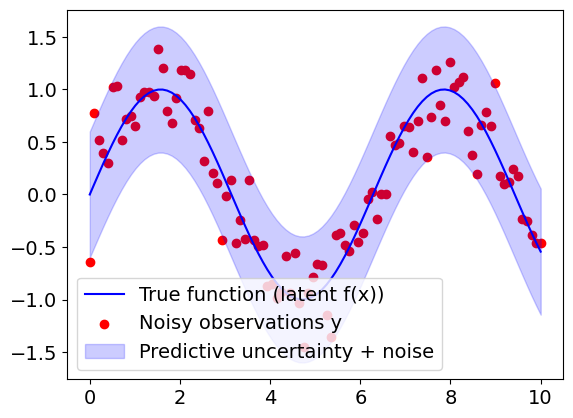

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# True function (latent)
def f(x):
    return np.sin(x)

# Generate points
X = np.linspace(0, 10, 100)
Y_true = f(X)

# Add Gaussian noise
noise_std = 0.3
Y_noisy = Y_true + np.random.normal(0, noise_std, size=X.shape)

# GP predictive mean (approximate as true here)
Y_pred = Y_true

# Plot
plt.plot(X, Y_true, 'b-', label='True function (latent f(x))')
plt.scatter(X, Y_noisy, c='r', label='Noisy observations y')
plt.fill_between(X, Y_pred - 2*noise_std, Y_pred + 2*noise_std, color='b', alpha=0.2, label='Predictive uncertainty + noise')
plt.legend()
plt.show()

In [ ]:
# model evaluation : Gaussian Posterior
torch.manual_seed(42)

model.eval()
likelihood.eval()

test_x = torch.linspace(0,1,101)

with torch.no_grad():
  f_pred = model(test_x)
  y_pred = likelihood(f_pred)

f_mean = f_pred.mean
f_var = f_pred.variance
f_covar = f_pred.covariance_matrix

print(f_mean)
print(f_var)
print(f_covar)

tensor([ 0.9085,  0.8811,  0.8850,  0.8733,  0.8440,  0.8245,  0.7952,  0.8069,
         0.7737,  0.7639,  0.7503,  0.7464,  0.7171,  0.6995,  0.6761,  0.6350,
         0.6253,  0.5999,  0.5921,  0.5960,  0.5706,  0.5608,  0.5120,  0.5139,
         0.5081,  0.4925,  0.4768,  0.4475,  0.4339,  0.3928,  0.3850,  0.3811,
         0.3577,  0.3479,  0.3421,  0.3069,  0.2913,  0.2581,  0.2581,  0.2307,
         0.2210,  0.2034,  0.1780,  0.1721,  0.1643,  0.0999,  0.1057,  0.0921,
         0.0764,  0.0589,  0.0257,  0.0178, -0.0251, -0.0271, -0.0427, -0.0544,
        -0.0779, -0.0935, -0.1013, -0.1501, -0.1638, -0.1657, -0.1814, -0.2029,
        -0.2263, -0.2400, -0.2927, -0.2790, -0.2888, -0.3337, -0.3259, -0.3513,
        -0.3786, -0.3786, -0.3943, -0.4255, -0.4372, -0.4665, -0.4529, -0.4919,
        -0.5114, -0.5251, -0.5271, -0.5310, -0.5700, -0.5915, -0.6072, -0.6130,
        -0.6462, -0.6814, -0.6814, -0.6970, -0.7224, -0.7575, -0.7614, -0.7654,
        -0.7771, -0.7986, -0.8298, -0.82

/usr/local/lib/python3.12/dist-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


In [ ]:
f_samples = f_pred.sample(sample_shape=torch.Size([5]))

/usr/local/lib/python3.12/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


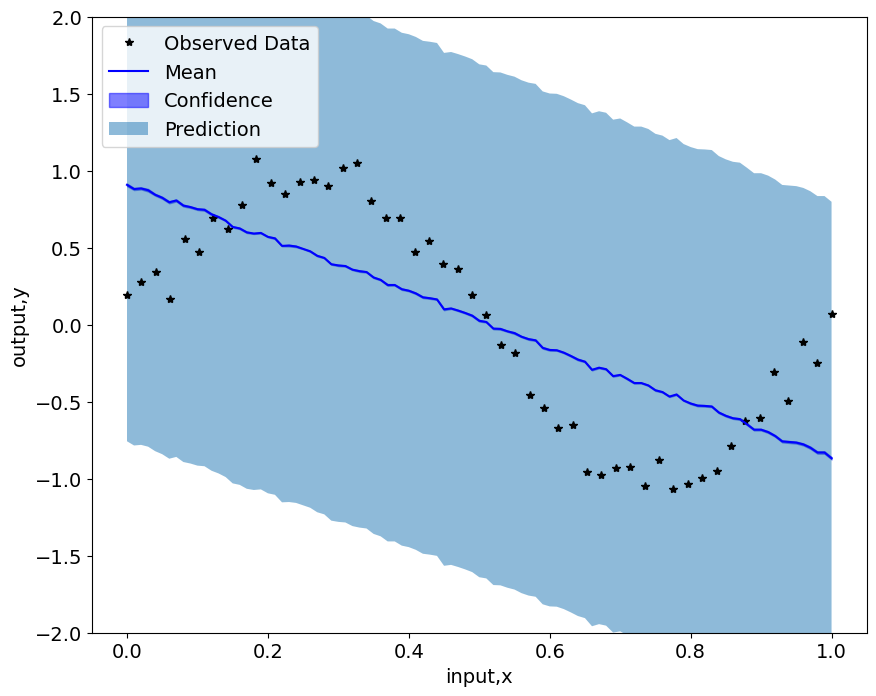

In [ ]:
# plot

fig,ax = plt.subplots(1,1,figsize=(10,8))

lower,upper = f_pred.confidence_region()
lower_y,upper_y = y_pred.confidence_region()

ax.plot(train_x.numpy(), train_y.numpy(), "k*")
ax.plot(test_x.numpy(), f_mean.numpy(), "b")
ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha = 0.5, color = "b")
ax.fill_between(test_x.numpy(), lower_y.numpy(), upper_y.numpy(), alpha=0.5)
ax.set_ylim([-2,2])
ax.legend(["Observed Data", "Mean", "Confidence", "Prediction"])
plt.xlabel("input,x")
plt.ylabel("output,y")
plt.rcParams.update({"font.size":14});

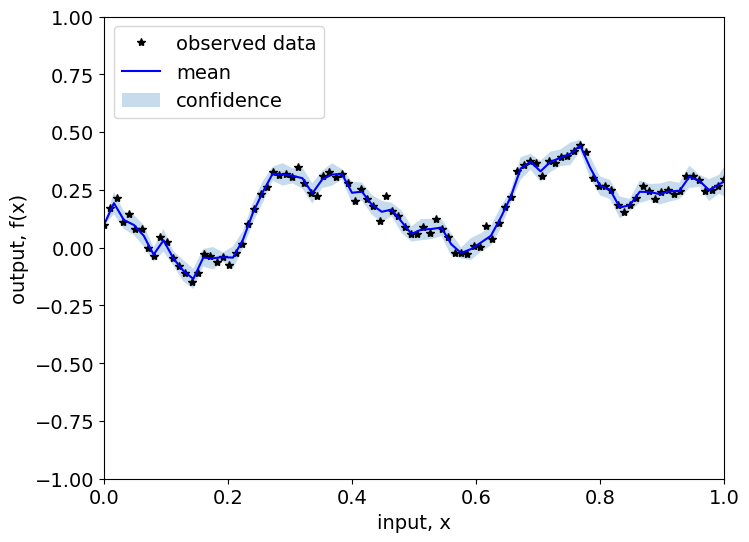

In [ ]:
# custom kernel

##############################################################
# Only modify this part of code block; replace FILL IN parts
##############################################################
# Create Brownian Motion Kernel
class BrownianMotionKernel(gpytorch.kernels.Kernel):
    # the brownian kernel is not stationary
    is_stationary = False

    # we will register the scale parameter when initializing the kernel
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # register the raw scale parameter
        self.register_parameter(name='raw_scale', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1)))

        # set the parameter constraint to be positive
        scale_constraint = Positive()

        # register the constraint
        self.register_constraint("raw_scale", scale_constraint)

    # now set up the 'actual' paramter
    @property
    def scale(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_scale_constraint.transform(self.raw_scale)

    @scale.setter
    def scale(self, value):
        return self._set_scale(value)

    def _set_scale(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_scale)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_scale=self.raw_scale_constraint.inverse_transform(value))

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # check statements
        assert x1.shape[-1] == 1 and x2.shape[-1] == 1 # only works for 1d input
        assert torch.all(x1 >= 0) and torch.all(x2 >= 0) # negative times are not currently supported

        # compute the pairwise minimums
        covar_matrix = torch.min(x1,x2.T)

        # make sure values are positive
        covar_matrix.where(covar_matrix <= 0, torch.as_tensor(1e-6))

        # return the scaled covariance matrix
        return self.scale * covar_matrix
##############################################################
##############################################################

# Generate training data with fixed seed
torch.manual_seed(42)
train_x = torch.linspace(0, 1, 100)
train_y = torch.cumsum(0.05*torch.randn(train_x.size()), dim=0)  # Simulate Brownian motion data

# Define GP model with Brownian motion kernel
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = BrownianMotionKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Set up the likelihood and model [here we use a fixed noise model]
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise = 1e-4*torch.ones_like(train_x))
model = GPModel(train_x, train_y, likelihood)

# Train the model
model.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs is the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
training_iter = 200
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Convert model to eval mode to make predictions on test data
model.eval()

# Make predictions
test_x = torch.linspace(0, 1.6, 101)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f_preds = model(test_x)

# Make plot of predictions
with torch.no_grad():
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    # get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_preds.mean.numpy(), 'b')
    # shade between the lower and upper confidence bounds for function f
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.25)
    ax.legend(['observed data', 'mean', 'confidence'], loc='upper left')
    plt.xlim(0, 1.0)
    plt.ylim(-1, 1)
    plt.xlabel('input, x')
    plt.ylabel('output, f(x)')
    plt.rcParams.update({'font.size':14});